<a href="https://colab.research.google.com/github/GitHubGetHope/ML_YAM/blob/master/blood_cells_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identify Blood Cell Subtypes From Images**
An important problem in blood diagnostics is classifying different types of blood cells : EOSINOPHIL vs NEUTROPHIL vs MONOCYTE vs LYMPHOCYTE vs basophil.

---

Membres:

Faik Marwa, Ellatifi Anass


In [ ]:
import numpy as np
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from keras.models import Model
import os
import cv2
import scipy
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle
%pwd

/content/gdrive/My Drive/Kaggle


'/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle datasets download -d paultimothymooney/blood-cells

 91% 98.0M/108M [00:00<00:00, 101MB/s]
100% 108M/108M [00:01<00:00, 106MB/s] 


In [ ]:
!ls

blood-cells.zip  kaggle.json


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip


In [ ]:
from tqdm import tqdm #make loops show a smart progress meter
from PIL import Image

#Load the data and labels from the given folder.
    
def load_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = np.array(Image.fromarray(img_file).resize(size=(80, 60 )))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = load_data('/content/gdrive/My Drive/Kaggle/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = load_data('/content/gdrive/My Drive/Kaggle/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)

100%|██████████| 624/624 [00:03<00:00, 156.49it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [ ]:
print("X train Shape is ",X_train.shape)
print("y train Shape is ",y_trainHot.shape)
print("z train Shape is ",z_trainHot.shape)

X train Shape is  (9957, 60, 80, 3)
y train Shape is  (9957, 5)
z train Shape is  (9957, 2)


In [ ]:
def keras_model():
    inp = Input(shape=(60,80,3))
    x = Conv2D(32, (11,11), padding="same",activation="relu")(inp)
    x = Conv2D(32, (7,7), padding="valid",activation="relu")(inp)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding="same",activation="relu")(x)
    x = Conv2D(32, (5, 5), padding="valid",activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same",activation="relu")(x)
    x = Conv2D(64, (3, 3), padding="valid",activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(1024,activation="relu")(x)
    x = Dropout(0.5)(x)
    y = Dense(5,activation="softmax")(x)
    model = Model(inp, y)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 54, 74, 32)        4736      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 37, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 37, 32)        25632     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 23, 33, 32)        25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 16, 64)        1849

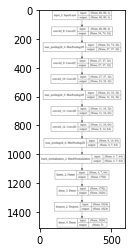

In [ ]:
model = keras_model()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.imshow(plt.imread('model_plot.png'))
model.summary()

In [ ]:
filepath = "./weight_tr5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,
         y_trainHot,
         epochs = 50,
         batch_size = 512,
         validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,
         verbose = 1)

Train on 9957 samples, validate on 2487 samples
Epoch 1/300
9957/9957 [==============================] - 158s 16ms/step - loss: 1.7021 - accuracy: 0.2959 - val_loss: 175.5571 - val_accuracy: 0.2493
Epoch 2/300


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


9957/9957 [==============================] - 155s 16ms/step - loss: 1.3364 - accuracy: 0.3608 - val_loss: 103.5316 - val_accuracy: 0.2493
Epoch 3/300
9957/9957 [==============================] - 155s 16ms/step - loss: 1.2675 - accuracy: 0.4081 - val_loss: 44.2027 - val_accuracy: 0.2730
Epoch 4/300
9957/9957 [==============================] - 155s 16ms/step - loss: 1.2027 - accuracy: 0.4521 - val_loss: 18.6601 - val_accuracy: 0.2509
Epoch 5/300
9957/9957 [==============================] - 156s 16ms/step - loss: 1.1028 - accuracy: 0.5165 - val_loss: 13.8174 - val_accuracy: 0.2493
Epoch 6/300
9957/9957 [==============================] - 155s 16ms/step - loss: 0.9939 - accuracy: 0.5660 - val_loss: 23.7976 - val_accuracy: 0.2493
Epoch 7/300
9957/9957 [==============================] - 155s 16ms/step - loss: 0.8442 - accuracy: 0.6524 - val_loss: 21.4320 - val_accuracy: 0.2493
Epoch 8/300
9957/9957 [==============================] - 155s 16ms/step - loss: 0.7286 - accuracy: 0.7027 - val_loss:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
## Loading Best Weights from the Gang
model.load_weights(filepath)